### Sample program for LSTM (N-d input/output)  
https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html  

#### Import libraries  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#### Parameters  

In [3]:
np.random.seed(11)
tf.random.set_seed(11)

# To show more rows and columns without "..."
pd.options.display.max_columns=999
pd.options.display.max_rows=999

#### Read CSV file  

In [4]:
# read data
df = pd.read_csv('weather_in_tokyo_and_icecream_in_japan-utf8.csv',
                 delimiter=',',skiprows=6, header=0)
print(df.shape)
print(df.info())
display(df.head())

(120, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   120 non-null    object 
 1   x1      120 non-null    float64
 2   x2      120 non-null    float64
 3   x3      120 non-null    int64  
 4   x4      120 non-null    int64  
 5   y1      120 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 5.8+ KB
None


,Month,x1,x2,x3,x4,y1
0,2003-1,9.3,101.0,46,0,331
1,2003-2,9.9,53.5,52,0,268
2,2003-3,12.7,159.5,49,0,365
3,2003-4,19.2,121.0,61,3,492
4,2003-5,22.4,172.5,65,7,632


#### Convert datatype of Month column to 'datetime'  

In [5]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   120 non-null    datetime64[ns]
 1   x1      120 non-null    float64       
 2   x2      120 non-null    float64       
 3   x3      120 non-null    int64         
 4   x4      120 non-null    int64         
 5   y1      120 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 5.8 KB
None


,Month,x1,x2,x3,x4,y1
0,2003-01-01,9.3,101.0,46,0,331
1,2003-02-01,9.9,53.5,52,0,268
2,2003-03-01,12.7,159.5,49,0,365
3,2003-04-01,19.2,121.0,61,3,492
4,2003-05-01,22.4,172.5,65,7,632


#### Time series plot  

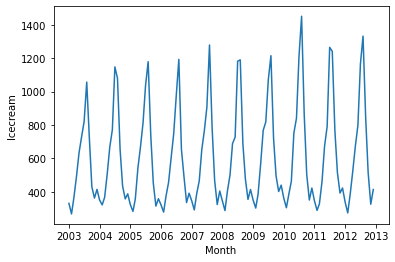

In [6]:
plt.plot(df['Month'], df['y1'])
plt.xlabel('Month')
plt.ylabel('Icecream')
plt.show()

#### Set parameters for training / prediction  

In [7]:
w = 24
n_out = 12
n_test = 12

#### Standardization of training data  

In [8]:
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
xy = df.drop(columns='Month')
sc.fit(xy[:-n_test])
xy_std = sc.transform(xy)
print(xy_std.shape)

(120, 5)


In [9]:
xy_std.shape

(120, 5)

#### Prepare for train data and teacher signal  

#### Using only x3 and x4

In [16]:
weather = xy_std[:, 2:-1]
print(weather.shape)
display(weather[:5])

(120, 2)


array([[0.25641026, 0.        ],
       [0.41025641, 0.        ],
       [0.33333333, 0.        ],
       [0.64102564, 0.09677419],
       [0.74358974, 0.22580645]])

In [17]:
icecream = xy_std[:, -1]
print(icecream.shape)
print(icecream[:5])

(120,)
[0.05325444 0.         0.08199493 0.18934911 0.30769231]


#### Prepare for windows of data  

In [18]:
x = []
y = []

n_months = icecream.shape[0]

for i in range(0, n_months-w-n_out):
    x.append(weather[i:i+w])
    y.append(icecream[i+w:i+w+n_out])
x = np.array(x)
y = np.array(y)
print(x.shape)  # debug

print(y.shape)  # debug


(84, 24, 2)
(84, 12)


#### Model building  

In [19]:
n_hidden = 20

# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss',
                      patience=10, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(x.shape[1],x.shape[2]),
               return_sequences=False))
model.add(Dense(n_out, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1840      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                252       
Total params: 2,092
Trainable params: 2,092
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss="mean_squared_error", optimizer='adam')

#### Training (learning)  

In [22]:
%%time

# Learning 
n_epochs = 500
val_split = 0.2
batch_size = 1

fit_log = model.fit(x[:-n_test], y[:-n_test], batch_size=batch_size, epochs=n_epochs,
                    validation_split=val_split, callbacks=[es_cb])

Train on 57 samples, validate on 15 samples
Epoch 1/500
57/57 [==============================] - 2s 44ms/sample - loss: 0.0972 - val_loss: 0.1020
Epoch 2/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0579 - val_loss: 0.0825
Epoch 3/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0510 - val_loss: 0.0784
Epoch 4/500
57/57 [==============================] - 0s 9ms/sample - loss: 0.0463 - val_loss: 0.0687
Epoch 5/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0411 - val_loss: 0.0651
Epoch 6/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0354 - val_loss: 0.0536
Epoch 7/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0282 - val_loss: 0.0430
Epoch 8/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0222 - val_loss: 0.0357
Epoch 9/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0171 - val_loss: 0.0284
Epoch 10/500
57/57 [==========================

#### Do prediction  

In [23]:
# Against training data
pred = model.predict(x[:-n_test])
print(pred.shape)  # debug

(72, 12)


In [24]:
# Future prediction
future_test = x[-n_test:]
print(future_test.shape)


(12, 24, 2)


In [25]:
future_result = model.predict(future_test)
print(future_result.shape)
future_result[:3]

(12, 12)


array([[0.07109339, 0.10617835, 0.09010059, 0.1325494 , 0.29263592,
        0.51434535, 0.72884685, 0.62656707, 0.45202178, 0.23655021,
        0.07095131, 0.06151346],
       [0.04201598, 0.10767102, 0.1468765 , 0.29214957, 0.5487049 ,
        0.6989949 , 0.7034768 , 0.4237252 , 0.16711044, 0.06772358,
        0.0199662 , 0.09318342],
       [0.0938067 , 0.15656309, 0.30319586, 0.5089202 , 0.6538792 ,
        0.63894546, 0.49018246, 0.21700911, 0.06549504, 0.0346131 ,
        0.06894789, 0.10192826]], dtype=float32)

#### Generalization performance  

In [26]:
mse = mean_squared_error(y[-n_test:], future_result)
print('mse=', mse)

mse= 0.00677906150674924


#### Plot of the results  

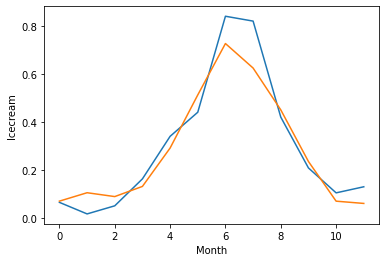

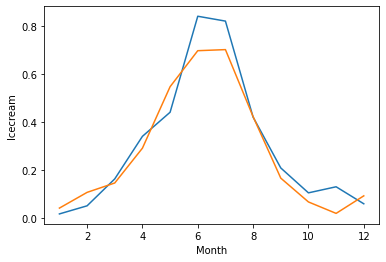

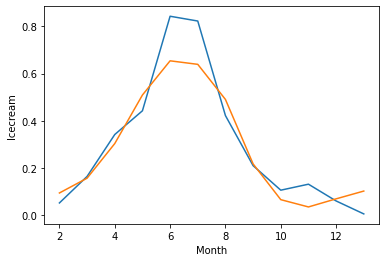

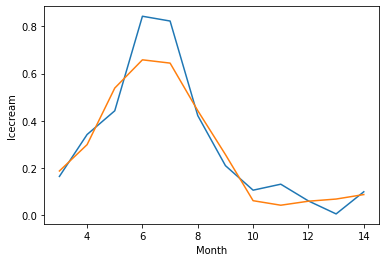

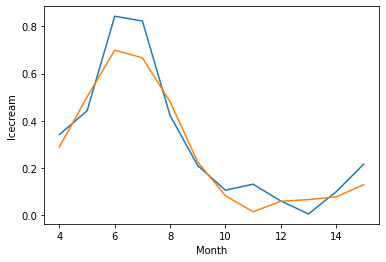

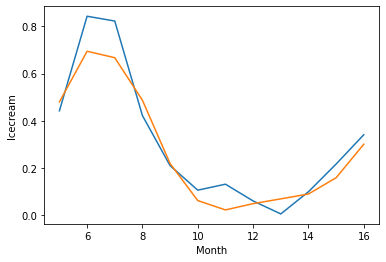

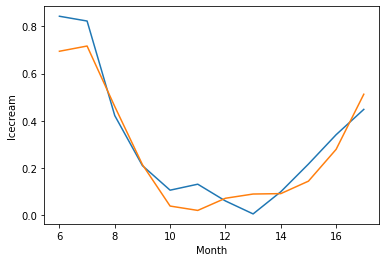

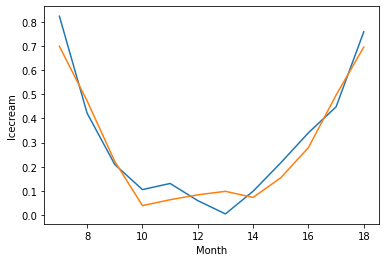

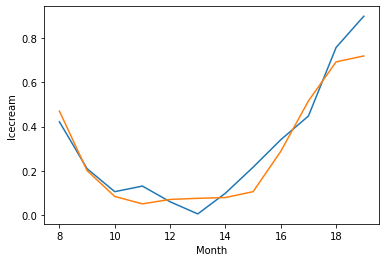

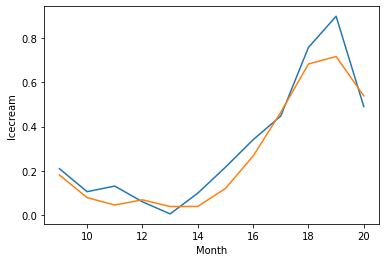

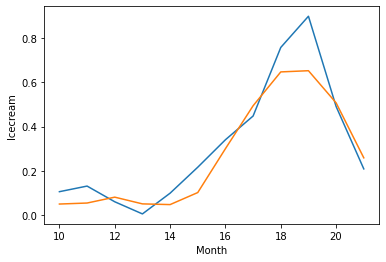

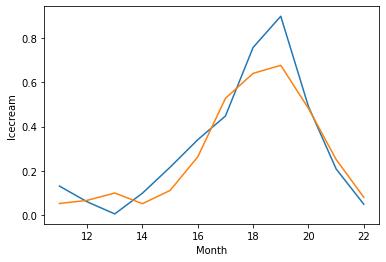

In [27]:
for i in range(n_test):
    plt.plot(range(i,i+n_out), y[i-n_test])
    plt.plot(range(i,i+n_out), future_result[i])
    plt.xlabel('Month')
    plt.ylabel('Icecream')
    plt.show()

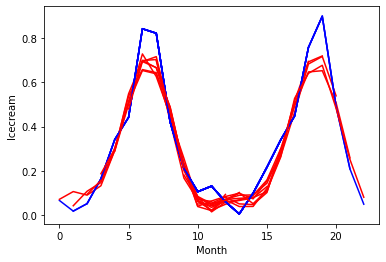

In [28]:
for i in range(n_test):
    plt.plot(range(i,i+n_out), y[i-n_test], c='b')
    plt.plot(range(i,i+n_out), future_result[i], c='r')
plt.xlabel('Month')
plt.ylabel('Icecream')
plt.show()

#### Plot of the log during the training  

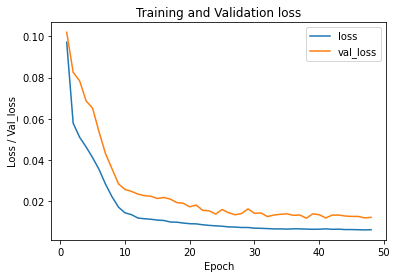

In [29]:
# Plot Training loss & Validation Loss
loss = fit_log.history["loss"]
val_loss = fit_log.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss" )
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss / Val_loss')
plt.legend()
plt.show()